In [ ]:
import time 
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
DATA_CSV  = "data.csv"
LABEL_CSV = "label.csv"
X = pd.read_csv(DATA_CSV, header=None).values.astype(np.float64)
y = pd.read_csv(LABEL_CSV, header=None).values.squeeze().astype(int)
K = np.unique(y).size
nonneg_shift = max(0.0, -X.min())
X_jac = X + nonneg_shift
EPS = 1e-12
def _row_norms(M: np.ndarray) -> np.ndarray:
    return np.sqrt((M * M).sum(axis=1, keepdims=True)) + EPS
def pairwise_sqeuclidean(A: np.ndarray, C: np.ndarray) -> np.ndarray:
    a2 = (A * A).sum(axis=1, keepdims=True)
    c2 = (C * C).sum(axis=1)[None, :]
    D = a2 + c2 - 2.0 * (A @ C.T)
    return np.maximum(D, 0.0)
def pairwise_one_minus_cosine(A: np.ndarray, C: np.ndarray) -> np.ndarray:
    A_n = A / _row_norms(A)
    C_n = C / _row_norms(C)
    S = A_n @ C_n.T
    S = np.clip(S, -1.0, 1.0)
    D = 1.0 - S
    return np.clip(D, 0.0, 2.0)
def pairwise_one_minus_gen_jaccard(A: np.ndarray, C: np.ndarray) -> np.ndarray:
    n, k = A.shape[0], C.shape[0]
    out = np.empty((n, k), dtype=np.float64)
    for j in range(k):
        num = np.minimum(A, C[j:j+1]).sum(axis=1) + EPS
        den = np.maximum(A, C[j:j+1]).sum(axis=1) + EPS
        out[:, j] = 1.0 - (num / den)
    out = np.clip(out, 0.0, 1.0)
    out[~np.isfinite(out)] = 0.0
    return out
def _distance_matrix(A: np.ndarray, C: np.ndarray, metric: str) -> np.ndarray:
    if metric == "euclidean":
        D = pairwise_sqeuclidean(A, C)         
    elif metric == "cosine":
        D = pairwise_one_minus_cosine(A, C)    
    elif metric == "jaccard":
        D = pairwise_one_minus_gen_jaccard(A, C)
    else:
        raise ValueError("metric must be 'euclidean', 'cosine', or 'jaccard'")
    D[~np.isfinite(D)] = 0.0
    return np.maximum(D, 0.0)
def _recompute_centroids(X: np.ndarray, labels: np.ndarray, K: int,
                         metric: str, rng: np.random.Generator) -> np.ndarray:
    d = X.shape[1]
    C = np.empty((K, d), dtype=np.float64)
    for k in range(K):
        mask = (labels == k)
        if not np.any(mask):
            C[k] = X[rng.integers(0, X.shape[0])]
            continue
        if metric == "cosine":
            v = X[mask].sum(axis=0)
            C[k] = v / (np.linalg.norm(v) + 1e-12)
        else:
            C[k] = X[mask].mean(axis=0)
    return C
def _kpp_init(X: np.ndarray, K: int, metric: str, rng: np.random.Generator) -> np.ndarray:
    n, d = X.shape
    if K > n:
        raise ValueError(f"K={K} cannot exceed the number of points n={n}.")
    C = np.empty((K, d), dtype=np.float64)
    # Pick the first center uniformly
    i0 = rng.integers(0, n)
    C[0] = X[i0]
    closest = _distance_matrix(X, C[:1], metric).squeeze()
    closest = np.maximum(closest, 0.0)
    for i in range(1, K):
        probs = np.maximum(closest.copy(), 0.0)
        total = probs.sum()
        if not np.isfinite(total) or total <= 0.0:
            idx = rng.integers(0, n)
        else:
            probs = probs / total
            probs = np.maximum(probs, 0.0)
            s = probs.sum()
            if s <= 0.0 or not np.isfinite(s):
                idx = rng.integers(0, n)
            else:
                probs = probs / s
                idx = rng.choice(n, p=probs)
        C[i] = X[idx]
        d_new = _distance_matrix(X, C[i:i+1], metric).squeeze()
        d_new = np.maximum(d_new, 0.0)
        closest = np.minimum(closest, d_new)
    return C
def kmeans_fit(X: np.ndarray,
               K: int,
               metric: str = "euclidean",
               max_iter: int = 200,
               seed: int = 0,
               stop_if_no_centroid_move: bool = True,
               stop_if_obj_increases: bool = True) -> dict:
    rng = np.random.default_rng(seed)
    C = _kpp_init(X, K, metric, rng)
    hist = []
    t0 = time.time()
    it = 0
    for it in range(1, max_iter + 1):
        D = _distance_matrix(X, C, metric)
        labels = D.argmin(axis=1)
        obj = float(D[np.arange(X.shape[0]), labels].sum())
        hist.append(obj)
        C_new = _recompute_centroids(X, labels, K, metric, rng)
        no_move = stop_if_no_centroid_move and np.allclose(C_new, C, rtol=1e-7, atol=1e-9)
        obj_up  = stop_if_obj_increases and (it > 1) and (hist[-1] > hist[-2] + 1e-12)
        C = C_new
        if no_move or obj_up:
            break
    t1 = time.time()
    return {
        "centroids": C,
        "labels": labels,
        "objective": hist[-1],
        "objective_hist": hist,
        "iters": it,
        "runtime_sec": t1 - t0,
    }
def cluster_majority_map(labels: np.ndarray, y: np.ndarray, K: int) -> dict:
    mapping = {}
    for k in range(K):
        m = (labels == k)
        if not np.any(m):
            mapping[k] = None
        else:
            vals, cnts = np.unique(y[m], return_counts=True)
            mapping[k] = vals[cnts.argmax()]
    return mapping
def in_sample_majority_accuracy(labels: np.ndarray, y: np.ndarray, K: int) -> float:
    mp = cluster_majority_map(labels, y, K)
    yhat = np.array([mp[lab] for lab in labels])
    mask = yhat != None
    return float((yhat[mask] == y[mask]).mean())

def predict_labels(X_new: np.ndarray, centroids: np.ndarray, metric: str) -> np.ndarray:
    D = _distance_matrix(X_new, centroids, metric)
    return D.argmin(axis=1)
SEED = 42
metrics = ["euclidean", "cosine", "jaccard"]
X_met = {"euclidean": X, "cosine": X, "jaccard": X_jac}
q1_rows = []
for m in metrics:
    out = kmeans_fit(X_met[m], K, metric=m, max_iter=200, seed=SEED)
    q1_rows.append({"method": m, "SSE_or_objective": out["objective"]})

qq1_d = pd.DataFrame(q1_rows).sort_values("SSE_or_objective")
print("\nQ1 SSE different methods here lower value is better :=")
print(qq1_d.to_string(index=False))
q2_in_rows = []
for m in metrics:
    out = kmeans_fit(X_met[m], K, metric=m, max_iter=200, seed=SEED)
    acc = in_sample_majority_accuracy(out["labels"], y, K)
    q2_in_rows.append({"method": m, "in_sample_accuracy": acc})
qq2_d = pd.DataFrame(q2_in_rows).sort_values("in_sample_accuracy", ascending=False)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
(train_idx, test_idx) = next(sss.split(X, y))
X_tr, y_tr = X[train_idx], y[train_idx]
X_te, y_te = X[test_idx], y[test_idx]
shift_tr = max(0.0, -X_tr.min())
X_tr_j = X_tr + shift_tr
X_te_j = X_te + shift_tr
X_tr_map = {"euclidean": X_tr, "cosine": X_tr, "jaccard": X_tr_j}
X_te_map = {"euclidean": X_te, "cosine": X_te, "jaccard": X_te_j}
q2_pred_rows = []
for m in metrics:
    out = kmeans_fit(X_tr_map[m], K, metric=m, max_iter=200, seed=SEED)
    mp = cluster_majority_map(out["labels"], y_tr, K)
    te_labels = predict_labels(X_te_map[m], out["centroids"], m)
    y_pred = np.array([mp.get(lbl, None) for lbl in te_labels])
    mask = y_pred != None
    acc = float((y_pred[mask] == y_te[mask]).mean())
    q2_pred_rows.append({"method": m, "predictive_accuracy": acc})
q2_pred_df = pd.DataFrame(q2_pred_rows).sort_values("predictive_accuracy", ascending=False)
print("\nQ2 Majority Accuracy ( vote ):")
print(qq2_d.to_string(index=False))
print("\nQ2 80 to 20 split predictive accuracy :- ")
print(q2_pred_df.to_string(index=False))
q3_rows = []
for m in metrics:
    out = kmeans_fit(
        X_met[m], K, metric=m, max_iter=500, seed=SEED,
        stop_if_no_centroid_move=True, stop_if_obj_increases=True
    )
    q3_rows.append({"method": m, "iters": out["iters"], "runtime_sec": out["runtime_sec"]})
q3_df = pd.DataFrame(q3_rows).sort_values("iters", ascending=False)
print("\nQ3 Runtime with all the iterations ( sharp stop time ) :- ")
print(q3_df.to_string(index=False))


Q1 SSE different methods here lower value is better :=
   method  SSE_or_objective
   cosine      2.456332e+03
  jaccard      6.445167e+03
euclidean      2.532360e+10

Q2 Majority Accuracy ( vote ):
   method  in_sample_accuracy
   cosine              0.6139
euclidean              0.6018
  jaccard              0.4480

Q2 80 to 20 split predictive accuracy :- 
   method  predictive_accuracy
   cosine               0.6155
euclidean               0.6105
  jaccard               0.5455

Q3 Runtime with all the iterations ( sharp stop time ) :- 
   method  iters  runtime_sec
   cosine     99    14.495975
euclidean     32     3.595807
  jaccard      2     1.296695


In [2]:

terminations = [
    ("no-change",           dict(stop_if_no_centroid_move=True,  stop_if_obj_increases=False, max_iter=500)),
    ("objective-increase",  dict(stop_if_no_centroid_move=False, stop_if_obj_increases=True,  max_iter=500)),
    ("max-iter",            dict(stop_if_no_centroid_move=False, stop_if_obj_increases=False, max_iter=100)),
]

q4_rows = []
for name, cfg in terminations:
    for m in metrics:
        out = kmeans_fit(
            X_met[m], K, metric=m, seed=SEED,
            max_iter=cfg["max_iter"],
            stop_if_no_centroid_move=cfg["stop_if_no_centroid_move"],
            stop_if_obj_increases=cfg["stop_if_obj_increases"],
        )
        q4_rows.append({
            "termination": name,
            "method": m,
            "SSE_or_objective": out["objective"],
            "iters": out["iters"],
        })
q4_df = pd.DataFrame(q4_rows).sort_values(["termination", "SSE_or_objective"])

print("\nQ4 Different termination rules result is as follows : ")
print(q4_df.to_string(index=False))


Q4 Different termination rules result is as follows : 
       termination    method  SSE_or_objective  iters
          max-iter    cosine      2.456342e+03    100
          max-iter   jaccard      6.017834e+03    100
          max-iter euclidean      2.532360e+10    100
         no-change    cosine      2.456339e+03    105
         no-change   jaccard      6.017834e+03     30
         no-change euclidean      2.532360e+10     32
objective-increase    cosine      2.456332e+03     99
objective-increase   jaccard      6.445167e+03      2
objective-increase euclidean      2.532360e+10    500


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
RATINGS_CSV = "ratings_small.csv" 
df = pd.read_csv(RATINGS_CSV)
display(df.head())


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
%pip install numpy==1.26.4

   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
   ------------------------------- -------- 12.6/15.8 MB 71.6 MB/s eta 0:00:01
   ---------------------------------------- 15.8/15.8 MB 66.5 MB/s  0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.5
    Uninstalling numpy-2.3.5:
      Successfully uninstalled numpy-2.3.5
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
  You can safely remove it manually.



(C) five fold averages , lower value is better :-
                 model     rmse      mae
   PMF (SVD, unbiased) 0.988960 0.758679
User-CF (cosine, k=40) 0.993150 0.767113
Item-CF (cosine, k=40) 0.995100 0.774792

(E) Impact of similarity measures (k=40):
   algo similarity  k     rmse      mae
Item-CF        msd 40 0.934569 0.721045
Item-CF    pearson 40 0.989143 0.768500
Item-CF     cosine 40 0.995100 0.774792
User-CF        msd 40 0.967779 0.743735
User-CF     cosine 40 0.993150 0.767113
User-CF    pearson 40 0.998342 0.773051


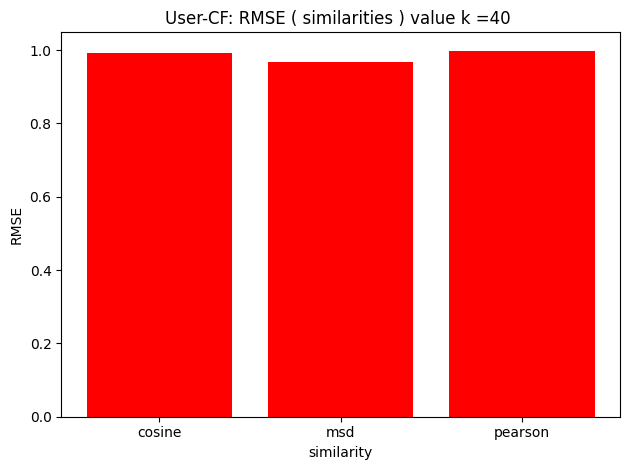

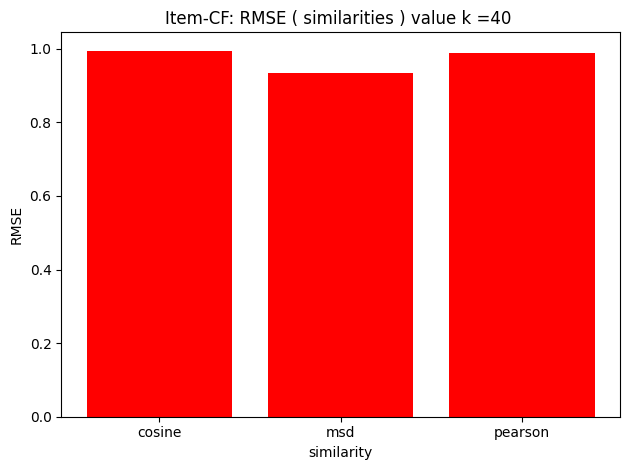


Sorted by RMSE best similarity value User-CF -> msd | Item-CF -> msd

(f) User-CF: RMSE/MAE vs k  
  k     rmse      mae
  5 0.986250 0.754829
 10 0.965007 0.737967
 20 0.962604 0.737742
 40 0.967779 0.743735
 60 0.971534 0.747845
 80 0.973995 0.750550
100 0.975584 0.752249

(f) Item-CF: RMSE/MAE vs k  
  k     rmse      mae
  5 1.022038 0.790352
 10 0.974983 0.754533
 20 0.947609 0.732584
 40 0.934569 0.721045
 60 0.931825 0.718473
 80 0.931343 0.717828
100 0.931815 0.718224


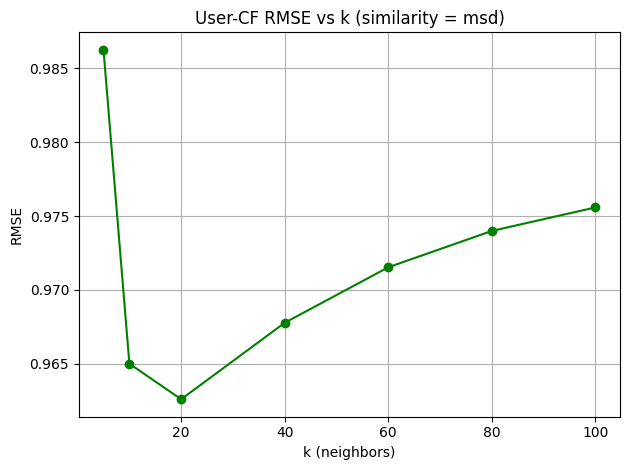

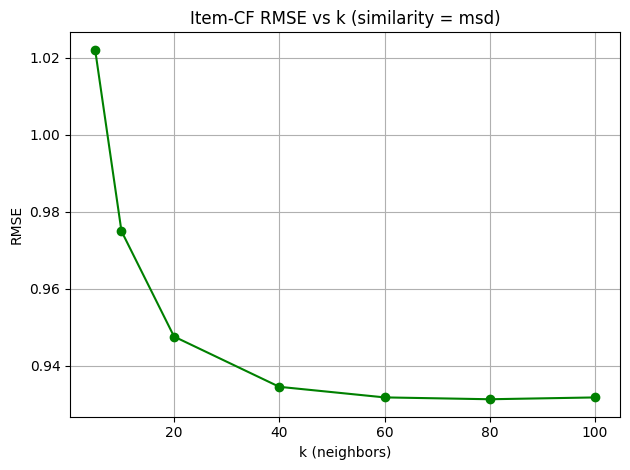


(g) Best value of k by RMSE 
User-CF (sim=msd): k=20, RMSE=0.962604, MAE=0.737742
Item-CF (sim=msd): k=80, RMSE=0.931343, MAE=0.717828


In [7]:
from surprise import Dataset, Reader
from surprise import SVD, KNNBasic
from surprise.model_selection import KFold, cross_validate
import os, sys, subprocess, warnings
warnings.filterwarnings("ignore")
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
CV = KFold(n_splits=5, random_state=42, shuffle=True)
def cv_mean_metrics(algo, data, cv_obj=CV):
    """Run 5-fold CV and return (mean_rmse, mean_mae)."""
    res = cross_validate(algo, data, measures=["RMSE", "MAE"], cv=cv_obj, verbose=False, n_jobs=1)
    return float(np.mean(res["test_rmse"])), float(np.mean(res["test_mae"]))
def eval_knn(user_based: bool, similarity: str, k: int = 40, min_k: int = 1):
    sim_options = {"name": similarity, "user_based": user_based, "min_support": 1}
    algo = KNNBasic(k=k, min_k=min_k, sim_options=sim_options, verbose=False)
    rmse, mae = cv_mean_metrics(algo, data, CV)
    return {"algo": f"{'User' if user_based else 'Item'}-CF",
            "similarity": similarity, "k": k, "rmse": rmse, "mae": mae}
np.set_printoptions(suppress=True, linewidth=140)
pd.options.display.float_format = "{:,.6f}".format
rows_c = []
pmf_algo = SVD(
    biased=False,
    n_factors=50,      
    n_epochs=20,
    lr_all=0.005,
    reg_all=0.02   
)
rmse, mae = cv_mean_metrics(pmf_algo, data, CV)
rows_c.append({"model": "PMF (SVD, unbiased)", "rmse": rmse, "mae": mae})


rows_c.append({**eval_knn(user_based=True,  similarity="cosine", k=40),  "model": "User-CF (cosine, k=40)"})
rows_c.append({**eval_knn(user_based=False, similarity="cosine", k=40),  "model": "Item-CF (cosine, k=40)"})

c_df = pd.DataFrame(rows_c)[["model", "rmse", "mae"]]
print("\n(C) five fold averages , lower value is better :-")
print(c_df.sort_values("rmse").to_string(index=False))


sims = ["cosine", "msd", "pearson"]
rows_e = []
for sim in sims:
    rows_e.append(eval_knn(user_based=True,  similarity=sim, k=40))
    rows_e.append(eval_knn(user_based=False, similarity=sim, k=40))
e_df = pd.DataFrame(rows_e)
print("\n(E) Impact of similarity measures (k=40):")
print(e_df.sort_values(["algo", "rmse"]).to_string(index=False))


def plot_bar_similarity(df_sim: pd.DataFrame, mode: str):
    sub = df_sim[df_sim["algo"] == mode]
    x = np.arange(len(sub))
    plt.figure()
    plt.bar(sub["similarity"], sub["rmse"],color='red')
    plt.title(f"{mode}: RMSE ( similarities ) value k =40 ")
    plt.xlabel("similarity")
    plt.ylabel("RMSE")
    plt.tight_layout()
    plt.show()

plot_bar_similarity(e_df, "User-CF")
plot_bar_similarity(e_df, "Item-CF")


def best_similarity(df_sim: pd.DataFrame, mode: str) -> str:
    sub = df_sim[df_sim["algo"] == mode]
    
    sub = sub.sort_values(["rmse", "mae"], ascending=[True, True]).reset_index(drop=True)
    return str(sub.loc[0, "similarity"])

best_sim_user = best_similarity(e_df, "User-CF")
best_sim_item = best_similarity(e_df, "Item-CF")
print(f"\nSorted by RMSE best similarity value User-CF -> {best_sim_user} | Item-CF -> {best_sim_item}")

k_grid = [5, 10, 20, 40, 60, 80, 100]
rows_f_user, rows_f_item = [], []

for k in k_grid:
    rows_f_user.append(eval_knn(user_based=True,  similarity=best_sim_user, k=k))
    rows_f_item.append(eval_knn(user_based=False, similarity=best_sim_item, k=k))

f_user_df = pd.DataFrame(rows_f_user)
f_item_df = pd.DataFrame(rows_f_item)

print("\n(f) User-CF: RMSE/MAE vs k  ")
print(f_user_df[ ['k','rmse','mae'] ].sort_values("k").to_string(index=False))
print("\n(f) Item-CF: RMSE/MAE vs k  ")
print(f_item_df[ ['k','rmse','mae'] ].sort_values("k").to_string(index=False))


def plot_line_k(dfk: pd.DataFrame, title: str):
    s = dfk.sort_values("k")
    plt.figure()
    plt.plot(s["k"], s["rmse"], marker="o",color='green')
    plt.title(title)
    plt.xlabel("k (neighbors)")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_line_k(f_user_df, f"User-CF RMSE vs k (similarity = {best_sim_user})")
plot_line_k(f_item_df, f"Item-CF RMSE vs k (similarity = {best_sim_item})")


best_k_user = f_user_df.loc[f_user_df["rmse"].idxmin(), ["k","rmse","mae"]]
best_k_item = f_item_df.loc[f_item_df["rmse"].idxmin(), ["k","rmse","mae"]]

print("\n(g) Best value of k by RMSE ")
print(f"User-CF (sim={best_sim_user}): k={int(best_k_user['k'])}, RMSE={best_k_user['rmse']:.6f}, MAE={best_k_user['mae']:.6f}")
print(f"Item-CF (sim={best_sim_item}): k={int(best_k_item['k'])}, RMSE={best_k_item['rmse']:.6f}, MAE={best_k_item['mae']:.6f}")


